Title - FAQ Categorization

Importing necessary python libraries and NLP libraries that will be required.

In [ ]:
!pip install fasttext

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import joblib
import fasttext.util
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Section 1: Load the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = "/content/drive/MyDrive/NLP_MINI/nlp_faq_dataset_cleaned.csv"
df = pd.read_csv(dataset_path)

df.head()

,Questions,Labels
0,How do I contact customer support?,General Inquiry
1,What are your business hours?,General Inquiry
2,Do you have a physical store location?,General Inquiry
3,Where is your company based?,General Inquiry
4,How can I provide feedback about your services?,General Inquiry


Section 2: Perform Exploratory Data Analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Questions  1024 non-null   object
 1   Labels     1024 non-null   object
dtypes: object(2)
memory usage: 16.1+ KB
None
                                         Questions           Labels
count                                         1024             1024
unique                                        1013                8
top     How do I enable two-factor authentication?  General Inquiry
freq                                             2              128
Labels
General Inquiry         128
Account Management      128
Payment Issues          128
Troubleshooting         128
Subscription Queries    128
Technical Support       128
Security & Privacy      128
Product Information     128
Name: count, dtype: int64


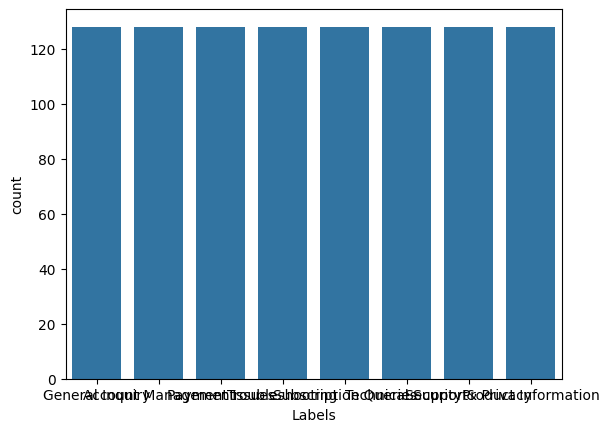

In [ ]:
print(df.info())
print(df.describe())
print(df['Labels'].value_counts())
sns.countplot(x=df['Labels'])
plt.show()

In [ ]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Questions    0
Labels       0
dtype: int64


In [ ]:
print("Total Questions:", len(df))
print("Unique Questions:", df['Questions'].nunique())
print("Duplicate Questions:", len(df) - df['Questions'].nunique())

Total Questions: 1024
Unique Questions: 1013
Duplicate Questions: 11


In [ ]:
df = df.drop_duplicates(subset=['Questions']).reset_index(drop=True)
print("New Total Questions:", len(df))
print("New Unique Questions:", df['Questions'].nunique())

New Total Questions: 1013
New Unique Questions: 1013


Section 3: Perform Text Processing on Dataset

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text


df['processed_text'] = df['Questions'].apply(preprocess_text)

Section 4: Generate NLP-Based Features

In [ ]:
import nltk
nltk.download('stopwords')

df['char_count'] = df['processed_text'].apply(len)
df['word_count'] = df['processed_text'].apply(lambda x: len(x.split()))
df['avg_word_length'] = df['char_count'] / df['word_count']

def count_stopwords(text):
    stopwords = set(nltk.corpus.stopwords.words('english'))
    return sum(1 for word in text.split() if word in stopwords)

df['stopword_count'] = df['processed_text'].apply(count_stopwords)

nlp_features = df[['char_count', 'word_count', 'avg_word_length', 'stopword_count']]
scaler = StandardScaler()
X_nlp = scaler.fit_transform(nlp_features)
y = df['Labels']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Section 5: Genarate Bag of Words, TF-IDF and FastText Features

In [ ]:
X_train_nlp, X_test_nlp, y_train, y_test = train_test_split(X_nlp, y, test_size=0.2, random_state=42)

bow_vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=5000)
X_bow = bow_vectorizer.fit_transform(df['processed_text'])

custom_stopwords = list(set(nltk.corpus.stopwords.words('english')))
custom_stopwords.extend(["you", "your", "do", "how", "can", "where", "what", "is", "the", "why"])
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5500,stop_words=custom_stopwords, min_df=4)
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('cc.en.300.bin')

def get_fasttext_vectors(text):
    words = text.split()
    vectors = [ft.get_word_vector(word) for word in words if word in ft.words]
    return np.mean(vectors, axis=0) if vectors else np.zeros(300)

df['fasttext_vectors'] = df['processed_text'].apply(get_fasttext_vectors)
X_fasttext = np.vstack(df['fasttext_vectors'].values)

Section 6: Train All Supervised Models on NLP-Based Features

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier()
}

for name, model in models.items():
    model.fit(X_train_nlp, y_train)
    y_pred = model.predict(X_test_nlp)
    print(f"{name} Accuracy on NLP Features: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))

Logistic Regression Accuracy on NLP Features: 0.22167487684729065
                      precision    recall  f1-score   support

  Account Management       0.29      0.67      0.40        18
     General Inquiry       0.09      0.08      0.09        24
      Payment Issues       0.34      0.38      0.36        34
 Product Information       0.18      0.06      0.10        31
  Security & Privacy       0.04      0.07      0.05        14
Subscription Queries       0.21      0.33      0.26        30
   Technical Support       0.50      0.04      0.07        25
     Troubleshooting       0.24      0.15      0.18        27

            accuracy                           0.22       203
           macro avg       0.24      0.22      0.19       203
        weighted avg       0.25      0.22      0.20       203

SVM Accuracy on NLP Features: 0.3054187192118227
                      precision    recall  f1-score   support

  Account Management       0.27      0.67      0.38        18
     General 

Section 7-9: Train Models on Bag of Words Features, TF-IDF Features and FastText Features

In [ ]:
X = df['processed_text']
y = df['Labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_bow = bow_vectorizer.transform(X_train).toarray()
X_test_bow = bow_vectorizer.transform(X_test).toarray()

joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
X_train_tfidf = tfidf_vectorizer.transform(X_train).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

X_train_fasttext = np.array([np.mean([ft[word] for word in sentence.split() if word in ft], axis=0) for sentence in X_train])
X_test_fasttext = np.array([np.mean([ft[word] for word in sentence.split() if word in ft], axis=0) for sentence in X_test])

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier()
}

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    print(f"{name} Accuracy on TF-IDF: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))


Logistic Regression Accuracy on TF-IDF: 0.6995073891625616
                      precision    recall  f1-score   support

  Account Management       0.58      0.58      0.58        26
     General Inquiry       0.59      0.80      0.68        25
      Payment Issues       0.79      0.73      0.76        26
 Product Information       0.76      0.64      0.70        25
  Security & Privacy       0.70      0.84      0.76        25
Subscription Queries       0.65      0.65      0.65        26
   Technical Support       0.82      0.58      0.68        24
     Troubleshooting       0.80      0.77      0.78        26

            accuracy                           0.70       203
           macro avg       0.71      0.70      0.70       203
        weighted avg       0.71      0.70      0.70       203

SVM Accuracy on TF-IDF: 0.7093596059113301
                      precision    recall  f1-score   support

  Account Management       0.61      0.65      0.63        26
     General Inquiry      

Section 10: Train Models on All Combined Features with TF-IDF

In [ ]:
X_combined = np.hstack((X_tfidf.toarray(), X_nlp, X_fasttext))
X_train_combined, X_test_combined, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

trained_models = {}

for name, model in models.items():
    model.fit(X_train_combined, y_train)
    y_pred = model.predict(X_test_combined)
    acc = accuracy_score(y_test, y_pred)

    trained_models[name] = model
    model_filename = f"{name.lower().replace(' ', '_')}.pkl"
    joblib.dump(model, model_filename)
    print(f"{name} trained on Combined Features and saved as {model_filename}")

    print(f"{name} Accuracy on Combined Features: {acc}")
    print(classification_report(y_test, y_pred))

Logistic Regression trained on Combined Features and saved as logistic_regression.pkl
Logistic Regression Accuracy on Combined Features: 0.7832512315270936
                      precision    recall  f1-score   support

  Account Management       0.71      0.94      0.81        18
     General Inquiry       0.78      0.75      0.77        24
      Payment Issues       0.78      0.74      0.76        34
 Product Information       0.95      0.68      0.79        31
  Security & Privacy       0.86      0.86      0.86        14
Subscription Queries       0.66      0.77      0.71        30
   Technical Support       0.77      0.80      0.78        25
     Troubleshooting       0.85      0.85      0.85        27

            accuracy                           0.78       203
           macro avg       0.80      0.80      0.79       203
        weighted avg       0.80      0.78      0.78       203

SVM trained on Combined Features and saved as svm.pkl
SVM Accuracy on Combined Features: 0.679802

Section 11: Save the Model and Make Predictions on Real-World Input

In [ ]:
loaded_models = {
    name: joblib.load(f"{name.lower().replace(' ', '_')}.pkl") for name in models.keys()
}

new_texts = [
    "How can I find my account settings?",
    "What are the payment methods available?",
    "Where can i search about customer support?"
]

tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')
new_texts_tfidf = tfidf_vectorizer.transform(new_texts)
new_texts_nlp = scaler.transform(pd.DataFrame({
    'char_count': [len(t) for t in new_texts],
    'word_count': [len(t.split()) for t in new_texts],
    'avg_word_length': [len(t) / len(t.split()) for t in new_texts],
    'stopword_count': [count_stopwords(t) for t in new_texts]
}))
new_texts_fasttext = np.vstack([get_fasttext_vectors(t) for t in new_texts])
new_texts_combined = np.hstack((new_texts_tfidf.toarray(), new_texts_nlp, new_texts_fasttext))

print("\nPredictions on Real-World Inputs:")
for name, model in loaded_models.items():
    predicted_categories = model.predict(new_texts_combined)

    print(f"\n{name} Predictions:")
    for text, category in zip(new_texts, predicted_categories):
        print(f"Question: {text} => Predicted Category: {category}")


Predictions on Real-World Inputs:

Logistic Regression Predictions:
Question: How can I find my account settings? => Predicted Category: Account Management
Question: What are the payment methods available? => Predicted Category: Payment Issues
Question: Where can i search about customer support? => Predicted Category: General Inquiry

SVM Predictions:
Question: How can I find my account settings? => Predicted Category: Troubleshooting
Question: What are the payment methods available? => Predicted Category: General Inquiry
Question: Where can i search about customer support? => Predicted Category: General Inquiry

Random Forest Predictions:
Question: How can I find my account settings? => Predicted Category: Account Management
Question: What are the payment methods available? => Predicted Category: Product Information
Question: Where can i search about customer support? => Predicted Category: General Inquiry


Section 12: Provide Analysis on Results

In [ ]:
def evaluate_models(X_train, X_test, y_train, y_test, feature_name):
    results = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results[model_name] = accuracy
        print(f"{model_name} Accuracy on {feature_name}: {accuracy:.4f}")

    return results

nlp_results = evaluate_models(X_train_nlp, X_test_nlp, y_train, y_test, "NLP Features")
bow_results = evaluate_models(X_train_bow, X_test_bow, y_train, y_test, "Bag of Words")
tfidf_results = evaluate_models(X_train_tfidf, X_test_tfidf, y_train, y_test, "TF-IDF")
fasttext_results = evaluate_models(X_train_fasttext, X_test_fasttext, y_train, y_test, "FastText")
combined_results = evaluate_models(X_train_combined, X_test_combined, y_train, y_test, "Combined Features")

all_results = {
    "NLP Features": nlp_results,
    "Bag of Words": bow_results,
    "TF-IDF": tfidf_results,
    "FastText": fasttext_results,
    "Combined Features": combined_results
}

best_feature_set = None
best_model = None
best_accuracy = 0

for feature, results in all_results.items():
    for model, acc in results.items():
        if acc > best_accuracy:
            best_accuracy = acc
            best_model = model
            best_feature_set = feature

joblib.dump(best_model, 'best_faq_model.pkl')

print("\nBest Model Analysis:")
print(f"Best Model: {best_model}")
print(f"Best Feature Set: {best_feature_set}")
print(f"Best Accuracy: {best_accuracy:.4f}")
print(f"Best model saved as best_faq_model.pkl")

Logistic Regression Accuracy on NLP Features: 0.2217
SVM Accuracy on NLP Features: 0.3054
Random Forest Accuracy on NLP Features: 0.2463
Logistic Regression Accuracy on Bag of Words: 0.1429
SVM Accuracy on Bag of Words: 0.0936
Random Forest Accuracy on Bag of Words: 0.1232
Logistic Regression Accuracy on TF-IDF: 0.1379
SVM Accuracy on TF-IDF: 0.1429
Random Forest Accuracy on TF-IDF: 0.1133
Logistic Regression Accuracy on FastText: 0.1133
SVM Accuracy on FastText: 0.1182
Random Forest Accuracy on FastText: 0.1379
Logistic Regression Accuracy on Combined Features: 0.7833
SVM Accuracy on Combined Features: 0.6798
Random Forest Accuracy on Combined Features: 0.7192

Best Model Analysis:
Best Model: Logistic Regression
Best Feature Set: Combined Features
Best Accuracy: 0.7833
Best model saved as best_faq_model.pkl
